In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)
import pickle

In [2]:
def process_embeddings_and_train(file_path, output_path):
    # Load data
    data = pd.read_pickle(file_path)

    # Separate features and labels
    X = data[[col for col in data.columns if col.startswith("emb_")]].values  # Select embedding columns
    y = data['label'].values

    # Define class weights
    class_weights = {0: 1, 1: 4}

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define classifiers with hyperparameter grids
    classifiers = {
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42, class_weight=class_weights),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [5,10, 20, None],
                "min_samples_split": [2, 5, 10]
            }
        },
        "Bagging": {
            "model": BaggingClassifier(estimator=RandomForestClassifier(random_state=42, class_weight=class_weights), random_state=42),
            "params": {
                "n_estimators": [10, 50, 100],
                "max_samples": [0.5, 0.7, 1.0]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 6, 10],
                "learning_rate": [0.01, 0.1, 0.3]
            }
        },
        "SVM": {
            "model": SVC(probability=True, class_weight=class_weights, random_state=42),
            "params": {
                "C": [0.1, 1, 10],
                "kernel": ["linear", "rbf", "poly"],
                "gamma": ["scale", "auto"]
            }
        }
    }

    # Train and evaluate each classifier
    results = {}
    for clf_name, clf_info in classifiers.items():
        print(f"\nTuning {clf_name}...")
        grid_search = GridSearchCV(
            estimator=clf_info["model"],
            param_grid=clf_info["params"],
            scoring='f1_macro',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        metrics = {
            "f1_micro": f1_score(y_test, y_pred, average='micro'),
            "f1_macro": f1_score(y_test, y_pred, average='macro'),
            "precision_macro": precision_score(y_test, y_pred, average='macro'),
            "recall_macro": recall_score(y_test, y_pred, average='macro'),
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred)
        }

        # Save results
        results[clf_name] = {
            "best_params": best_params,
            "metrics": metrics
        }

        # Print metrics and best parameters
        print(f"\n{clf_name} Results:")
        print(f"Best Parameters: {best_params}")
        for metric, value in metrics.items():
            if metric != "classification_report":
                print(f"{metric.capitalize()}: {value:.4f}")
            else:
                print(f"\n{metric.capitalize()}:\n{value}")

    # Plot F1 Macro Scores
    f1_scores = {clf: result['metrics']['f1_macro'] for clf, result in results.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.title('F1 Macro Scores of Classifiers')
    plt.xlabel('Classifier')
    plt.ylabel('F1 Macro Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Accuracies
    accuracies = {clf: result['metrics']['accuracy'] for clf, result in results.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Accuracy of Classifiers')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save all results to output path
    with open(output_path, "wb") as f:
        pickle.dump(results, f)
    print(f"\nResults saved to {output_path}")



# Codebert

Classification using AVG embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
F1_micro: 0.8133
F1_macro: 0.7721
Precision_macro: 0.7622
Recall_macro: 0.7864
Accuracy: 0.8133

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       814
           1       0.63      0.73      0.68       295

    accuracy                           0.81      1109
   macro avg       0.76      0.79      0.77      1109
weighted avg       0.82      0.81      0.82      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.8197
F1_macro: 0.7660
Precision_macro: 0.7698
Recall_macro: 0.7626
Accuracy: 0.8197

Classification_report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       814
           1       0.67      0.64      0.65       295

    accu

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
F1_micro: 0.8151
F1_macro: 0.7646
Precision_macro: 0.7632
Recall_macro: 0.7660
Accuracy: 0.8151

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       814
           1       0.65      0.66      0.66       295

    accuracy                           0.82      1109
   macro avg       0.76      0.77      0.76      1109
weighted avg       0.82      0.82      0.82      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1_micro: 0.7421
F1_macro: 0.7134
Precision_macro: 0.7092
Recall_macro: 0.7606
Accuracy: 0.7421

Classification_report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       814
           1       0.51      0.80      0.62       295

    accuracy                           0.74      1109
   macro avg       0.71      0

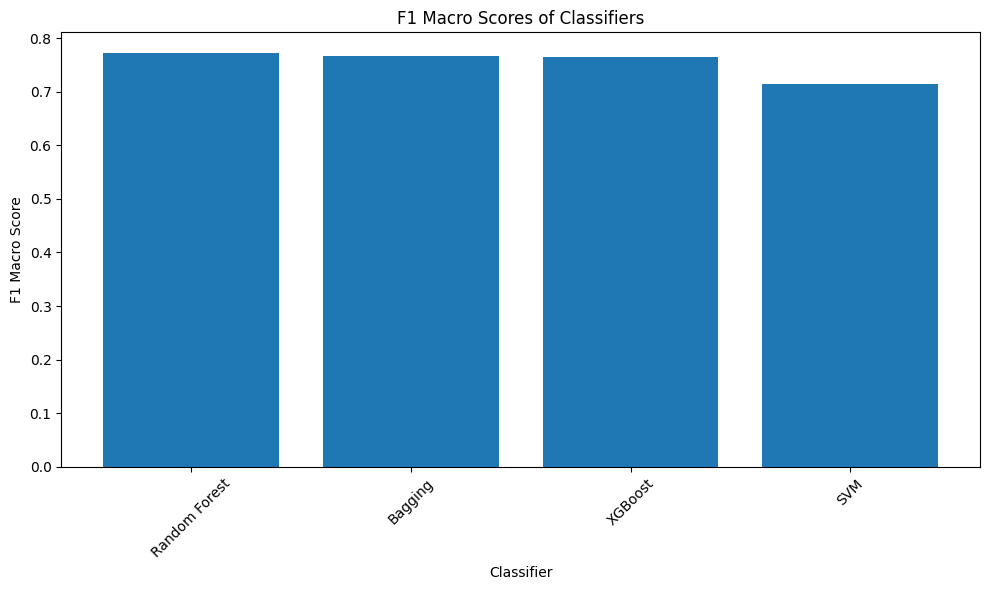

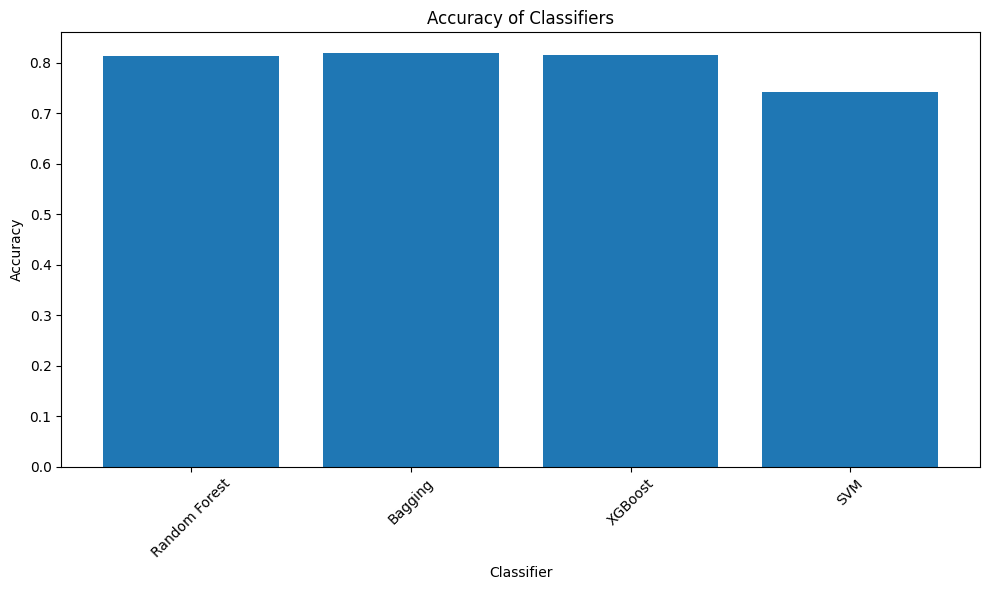


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_avg.pkl


In [3]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codebert_embeddings/processed_embeddings/codebert_base_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
F1_micro: 0.8061
F1_macro: 0.7654
Precision_macro: 0.7546
Recall_macro: 0.7826
Accuracy: 0.8061

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       814
           1       0.61      0.73      0.67       295

    accuracy                           0.81      1109
   macro avg       0.75      0.78      0.77      1109
weighted avg       0.82      0.81      0.81      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.8296
F1_macro: 0.7796
Precision_macro: 0.7825
Recall_macro: 0.7769
Accuracy: 0.8296

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       814
           1       0.69      0.66      0.67       295

    accur

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [15:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
F1_micro: 0.8142
F1_macro: 0.7601
Precision_macro: 0.7624
Recall_macro: 0.7578
Accuracy: 0.8142

Classification_report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       814
           1       0.66      0.64      0.65       295

    accuracy                           0.81      1109
   macro avg       0.76      0.76      0.76      1109
weighted avg       0.81      0.81      0.81      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
F1_micro: 0.7583
F1_macro: 0.7304
Precision_macro: 0.7241
Recall_macro: 0.7781
Accuracy: 0.7583

Classification_report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       814
           1       0.53      0.82      0.64       295

    accuracy                           0.76      1109
   macro avg       0.72    

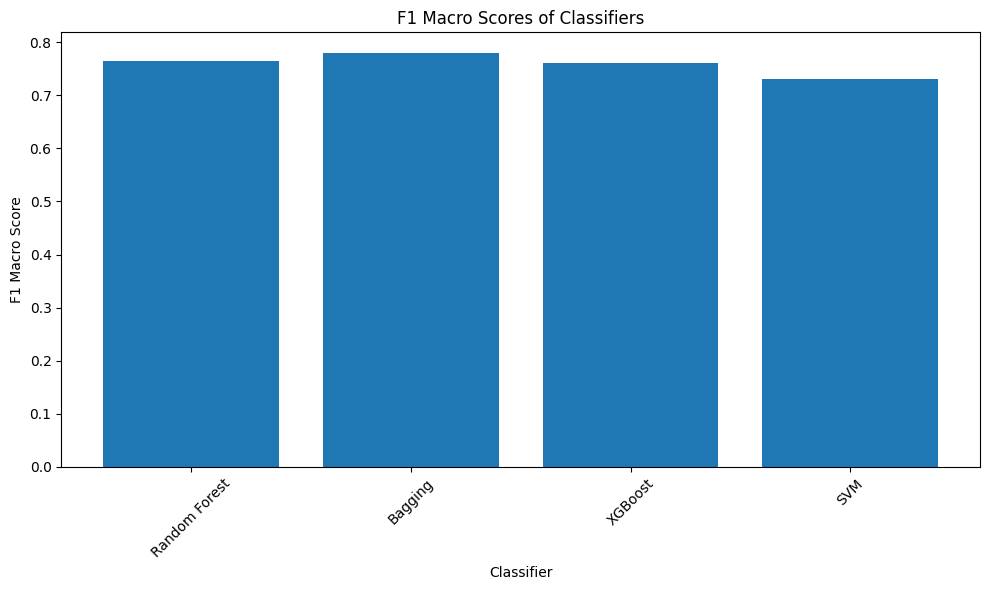

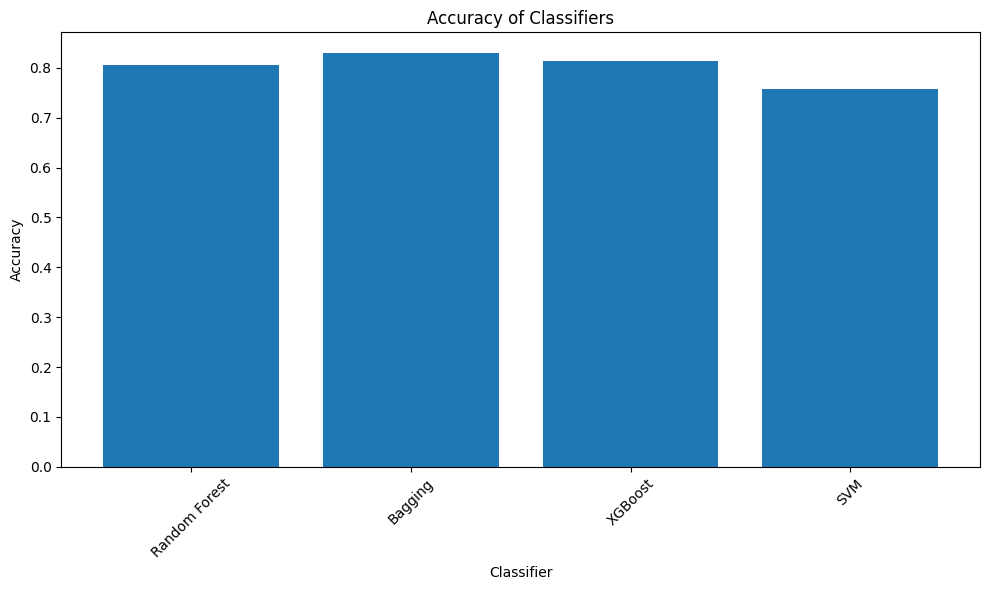


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_sum.pkl


In [4]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codebert_embeddings/processed_embeddings/codebert_base_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# codeT5 base

Classification using AVG embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
F1_micro: 0.6357
F1_macro: 0.6226
Precision_macro: 0.6593
Recall_macro: 0.7021
Accuracy: 0.6357

Classification_report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       814
           1       0.41      0.84      0.55       295

    accuracy                           0.64      1109
   macro avg       0.66      0.70      0.62      1109
weighted avg       0.78      0.64      0.66      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.6267
F1_macro: 0.5851
Precision_macro: 0.5905
Recall_macro: 0.6128
Accuracy: 0.6267

Classification_report:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72       814
           1       0.37      0.58      0.45       295

    accura

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
F1_micro: 0.7755
F1_macro: 0.6180
Precision_macro: 0.7530
Recall_macro: 0.6082
Accuracy: 0.7755

Classification_report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       814
           1       0.73      0.25      0.37       295

    accuracy                           0.78      1109
   macro avg       0.75      0.61      0.62      1109
weighted avg       0.77      0.78      0.73      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}
F1_micro: 0.6204
F1_macro: 0.6071
Precision_macro: 0.6453
Recall_macro: 0.6841
Accuracy: 0.6204

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       814
           1       0.40      0.82      0.53       295

    accuracy                           0.62      1109
   macro avg       0.65      

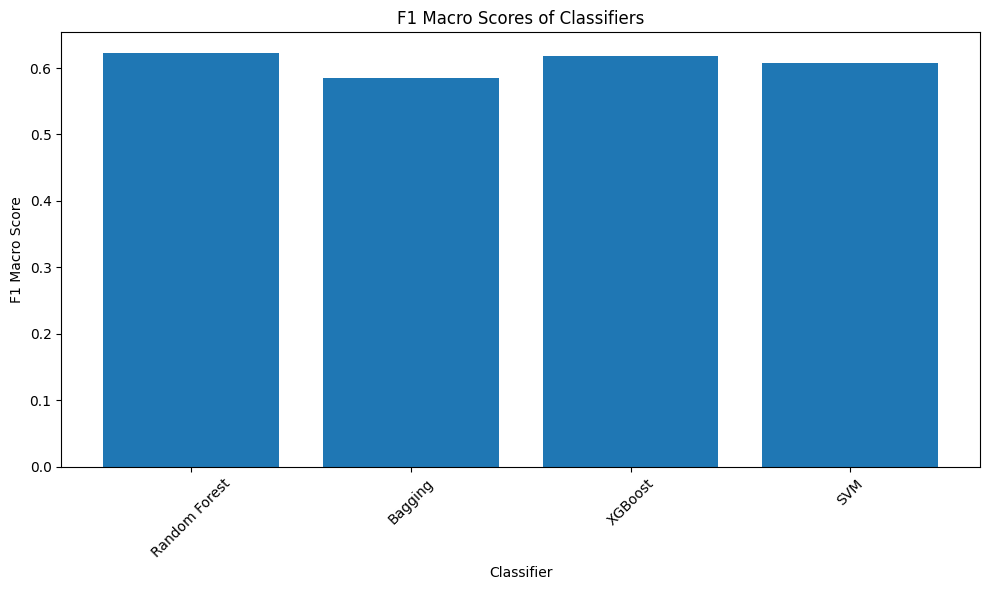

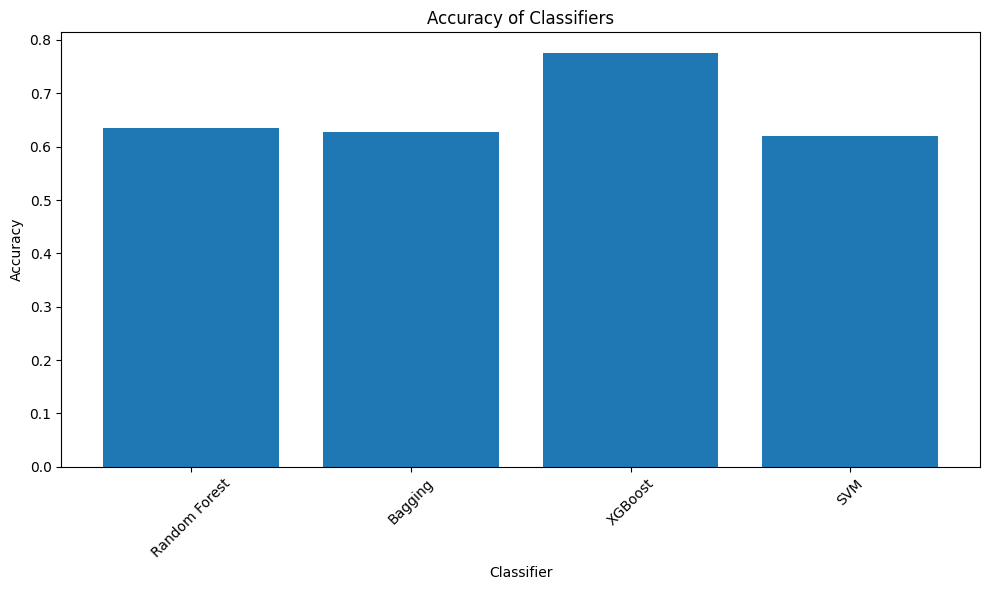


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_avg.pkl


In [5]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_base_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
F1_micro: 0.6258
F1_macro: 0.6102
Precision_macro: 0.6423
Recall_macro: 0.6813
Accuracy: 0.6258

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       814
           1       0.40      0.80      0.53       295

    accuracy                           0.63      1109
   macro avg       0.64      0.68      0.61      1109
weighted avg       0.76      0.63      0.65      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 10}
F1_micro: 0.6384
F1_macro: 0.6028
Precision_macro: 0.6097
Recall_macro: 0.6381
Accuracy: 0.6384

Classification_report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       814
           1       0.39      0.64      0.48       295

    accura

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
F1_micro: 0.7647
F1_macro: 0.6058
Precision_macro: 0.7157
Recall_macro: 0.5987
Accuracy: 0.7647

Classification_report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       814
           1       0.65      0.24      0.36       295

    accuracy                           0.76      1109
   macro avg       0.72      0.60      0.61      1109
weighted avg       0.74      0.76      0.72      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
F1_micro: 0.6186
F1_macro: 0.6049
Precision_macro: 0.6425
Recall_macro: 0.6807
Accuracy: 0.6186

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       814
           1       0.39      0.81      0.53       295

    accuracy                           0.62      1109
   macro avg       0.64   

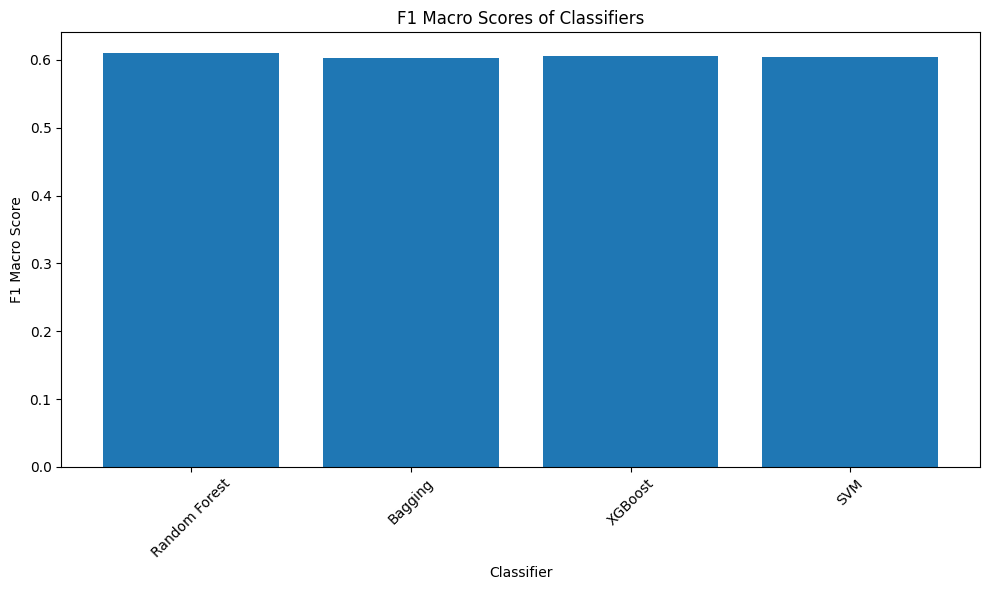

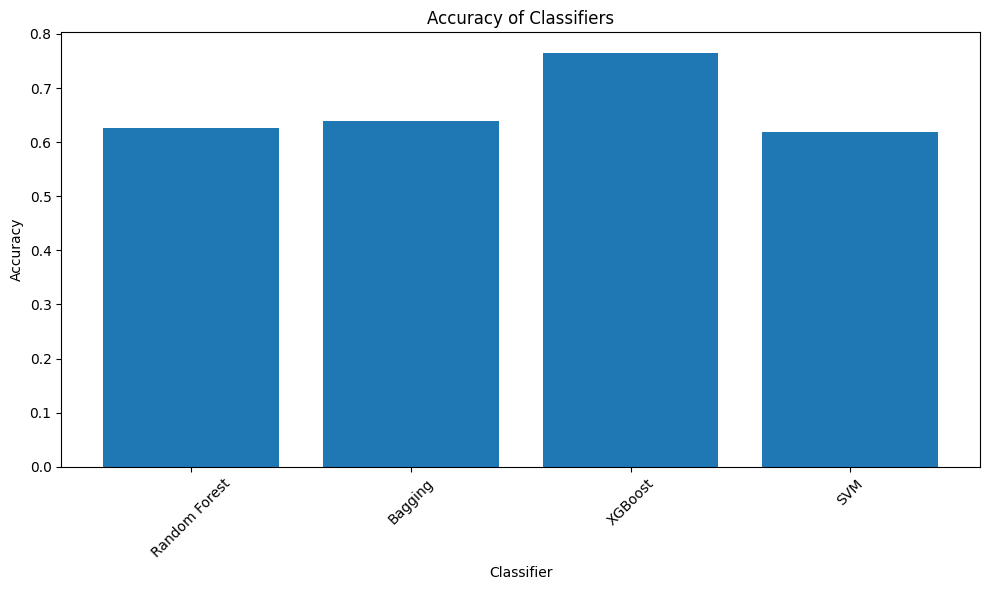


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_sum.pkl


In [6]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_base_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# codeT5 small

Classification using AVG embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
F1_micro: 0.8161
F1_macro: 0.7522
Precision_macro: 0.7684
Recall_macro: 0.7407
Accuracy: 0.8161

Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       814
           1       0.68      0.58      0.63       295

    accuracy                           0.82      1109
   macro avg       0.77      0.74      0.75      1109
weighted avg       0.81      0.82      0.81      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 100}
F1_micro: 0.7935
F1_macro: 0.6501
Precision_macro: 0.8042
Recall_macro: 0.6324
Accuracy: 0.7935

Classification_report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       814
           1       0.82      0.29      0.43       295

    acc

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
F1_micro: 0.8115
F1_macro: 0.7426
Precision_macro: 0.7636
Recall_macro: 0.7290
Accuracy: 0.8115

Classification_report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       814
           1       0.68      0.55      0.61       295

    accuracy                           0.81      1109
   macro avg       0.76      0.73      0.74      1109
weighted avg       0.80      0.81      0.80      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1_micro: 0.7592
F1_macro: 0.7026
Precision_macro: 0.6968
Recall_macro: 0.7106
Accuracy: 0.7592

Classification_report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       814
           1       0.54      0.61      0.57       295

    accuracy                           0.76      1109
   macro avg       0.70      0

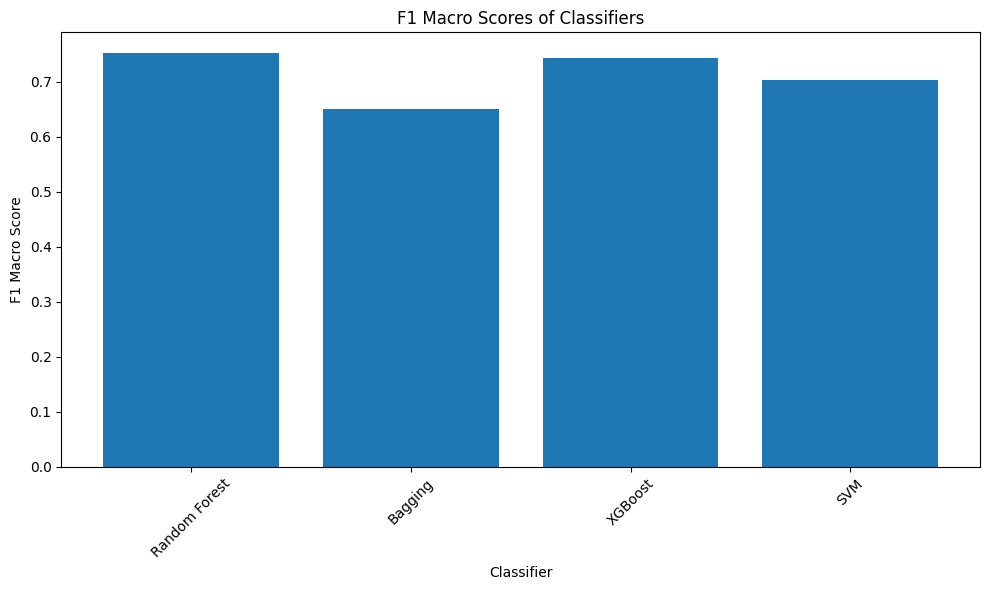

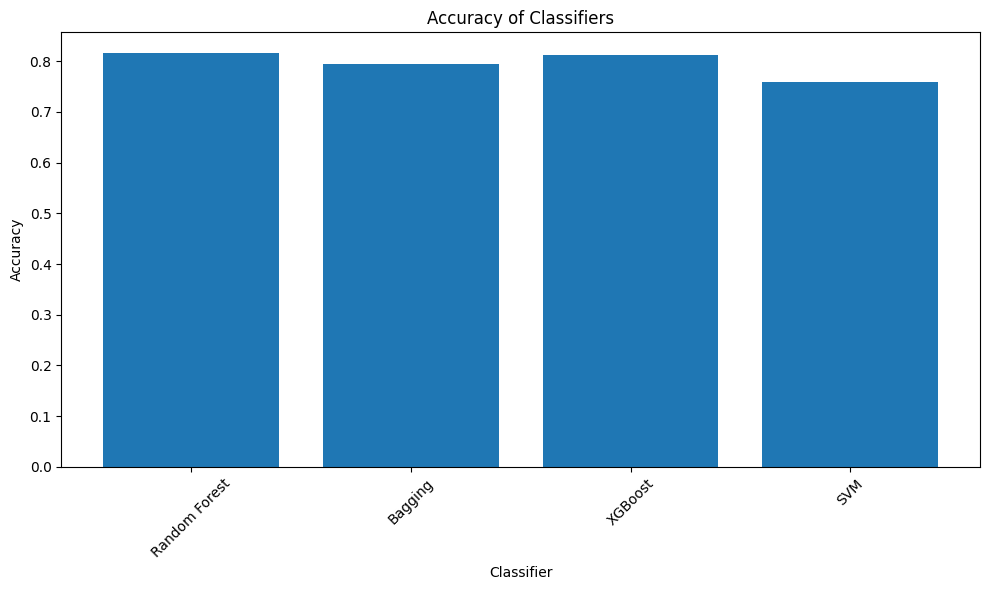


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_avg.pkl


In [7]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_small_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_avg.pkl"  
process_embeddings_and_train(file_path, output_path)

Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
F1_micro: 0.8142
F1_macro: 0.7562
Precision_macro: 0.7633
Recall_macro: 0.7503
Accuracy: 0.8142

Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       814
           1       0.66      0.61      0.64       295

    accuracy                           0.81      1109
   macro avg       0.76      0.75      0.76      1109
weighted avg       0.81      0.81      0.81      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.7944
F1_macro: 0.6688
Precision_macro: 0.7777
Recall_macro: 0.6481
Accuracy: 0.7944

Classification_report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       814
           1       0.76      0.34      0.46       295

    accu

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [17:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
F1_micro: 0.8142
F1_macro: 0.7446
Precision_macro: 0.7686
Recall_macro: 0.7297
Accuracy: 0.8142

Classification_report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       814
           1       0.69      0.55      0.61       295

    accuracy                           0.81      1109
   macro avg       0.77      0.73      0.74      1109
weighted avg       0.81      0.81      0.81      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1_micro: 0.7529
F1_macro: 0.7251
Precision_macro: 0.7197
Recall_macro: 0.7733
Accuracy: 0.7529

Classification_report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       814
           1       0.52      0.82      0.64       295

    accuracy                           0.75      1109
   macro avg       0.72      

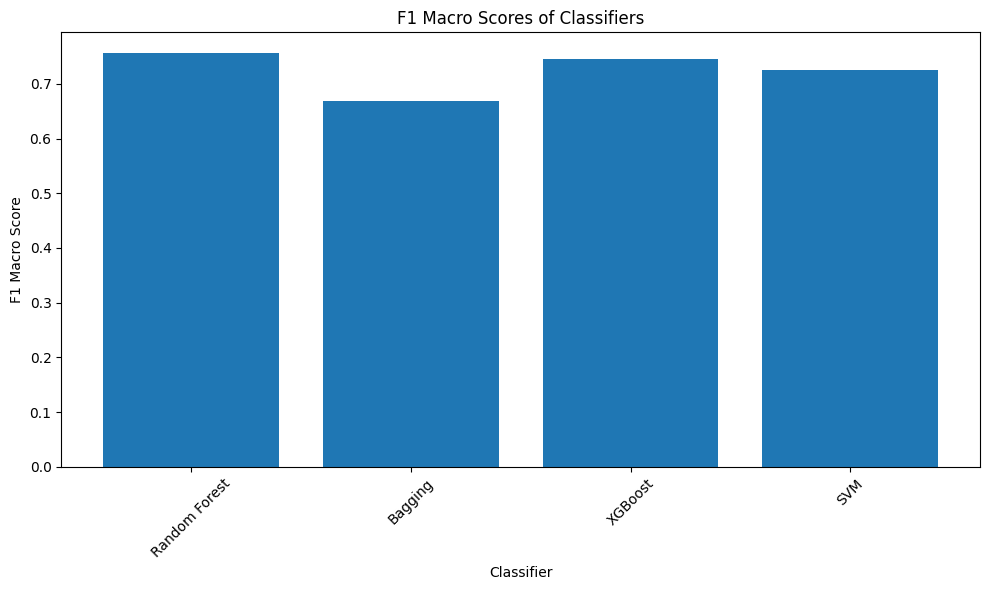

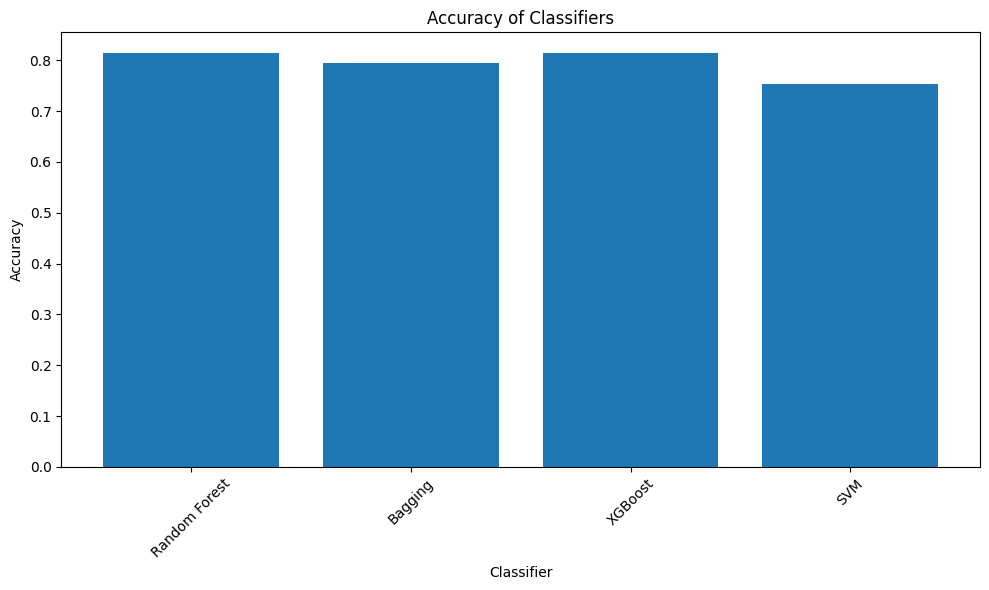


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_sum.pkl


In [8]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_small_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# Cubert

Classification using AVG embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
F1_micro: 0.8088
F1_macro: 0.7659
Precision_macro: 0.7567
Recall_macro: 0.7790
Accuracy: 0.8088

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       814
           1       0.62      0.72      0.67       295

    accuracy                           0.81      1109
   macro avg       0.76      0.78      0.77      1109
weighted avg       0.82      0.81      0.81      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.8142
F1_macro: 0.7498
Precision_macro: 0.7658
Recall_macro: 0.7384
Accuracy: 0.8142

Classification_report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       814
           1       0.68      0.58      0.62       295

    accu

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [17:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
F1_micro: 0.8142
F1_macro: 0.7539
Precision_macro: 0.7641
Recall_macro: 0.7459
Accuracy: 0.8142

Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       814
           1       0.67      0.60      0.63       295

    accuracy                           0.81      1109
   macro avg       0.76      0.75      0.75      1109
weighted avg       0.81      0.81      0.81      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
F1_micro: 0.7890
F1_macro: 0.7498
Precision_macro: 0.7382
Recall_macro: 0.7731
Accuracy: 0.7890

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       814
           1       0.58      0.74      0.65       295

    accuracy                           0.79      1109
   macro avg       0.74     

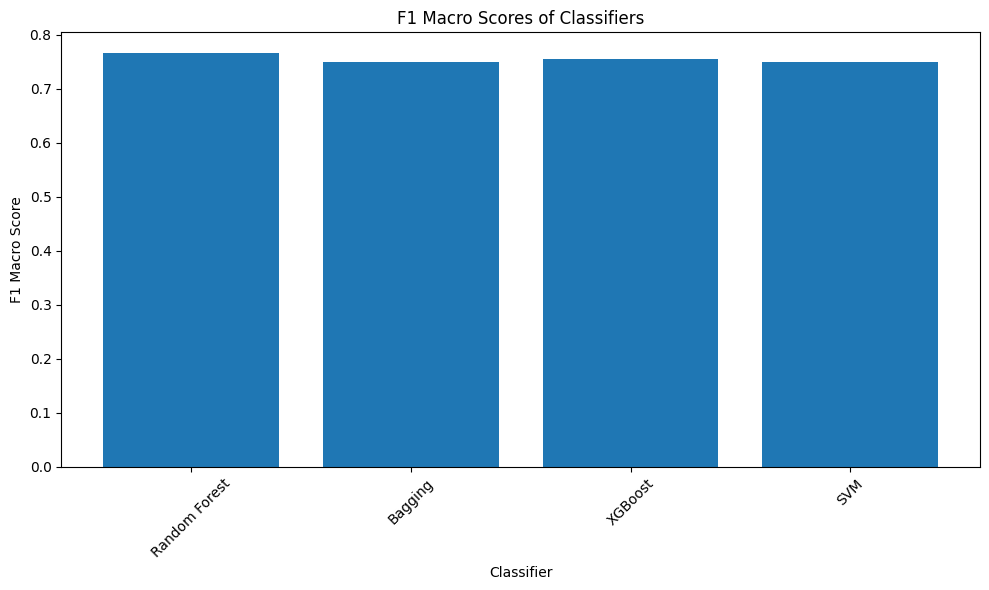

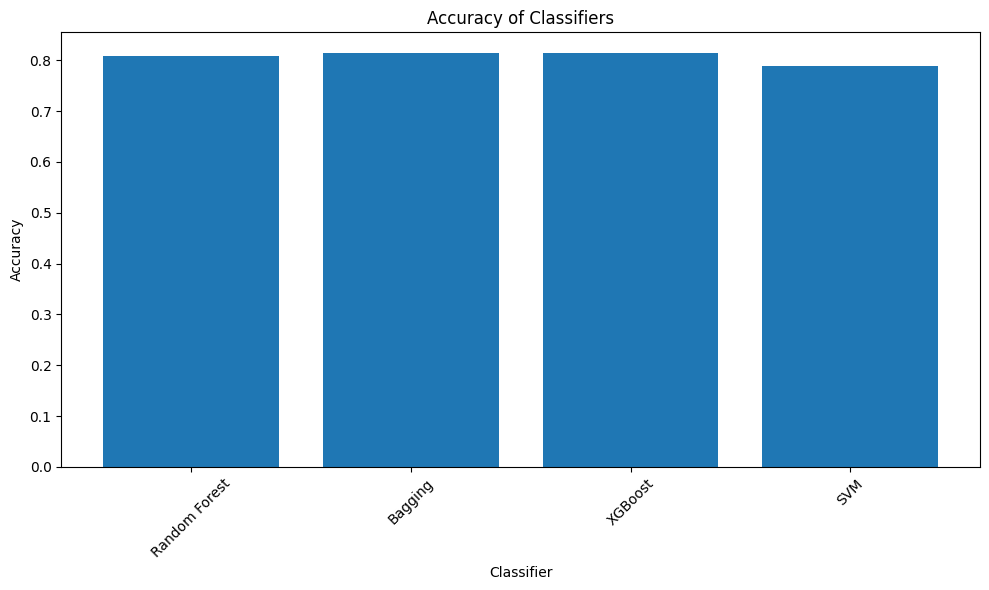


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_avg.pkl


In [9]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/cubert_embeddings/processed_embeddings/cubert_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
F1_micro: 0.8106
F1_macro: 0.7668
Precision_macro: 0.7584
Recall_macro: 0.7781
Accuracy: 0.8106

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       814
           1       0.63      0.71      0.67       295

    accuracy                           0.81      1109
   macro avg       0.76      0.78      0.77      1109
weighted avg       0.82      0.81      0.81      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.8188
F1_macro: 0.7561
Precision_macro: 0.7721
Recall_macro: 0.7447
Accuracy: 0.8188

Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       814
           1       0.69      0.59      0.63       295

    accu

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
F1_micro: 0.8106
F1_macro: 0.7498
Precision_macro: 0.7589
Recall_macro: 0.7424
Accuracy: 0.8106

Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       814
           1       0.66      0.60      0.63       295

    accuracy                           0.81      1109
   macro avg       0.76      0.74      0.75      1109
weighted avg       0.81      0.81      0.81      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
F1_micro: 0.7421
F1_macro: 0.7123
Precision_macro: 0.7074
Recall_macro: 0.7573
Accuracy: 0.7421

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       814
           1       0.51      0.79      0.62       295

    accuracy                           0.74      1109
   macro avg       0.71     

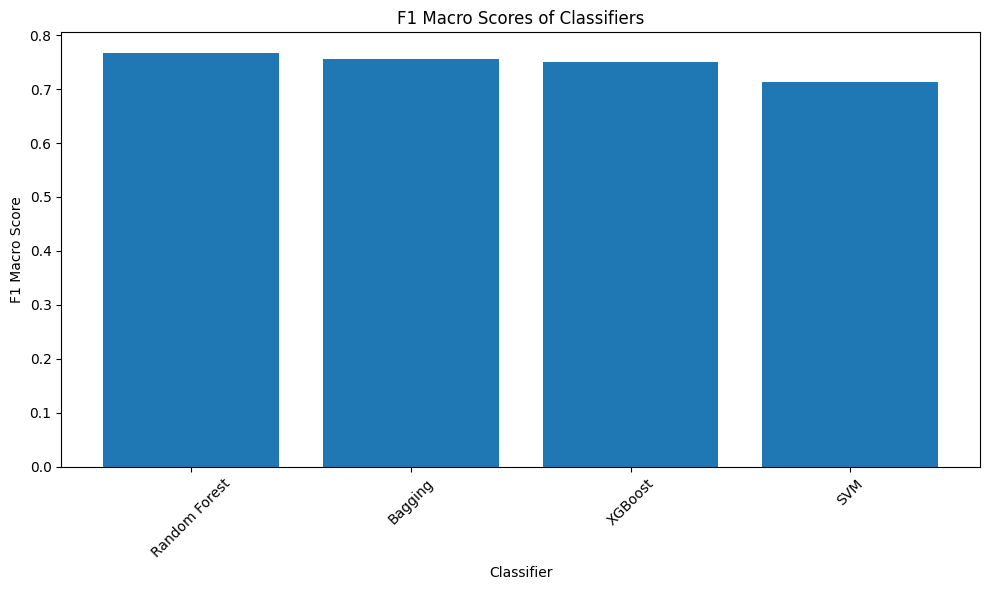

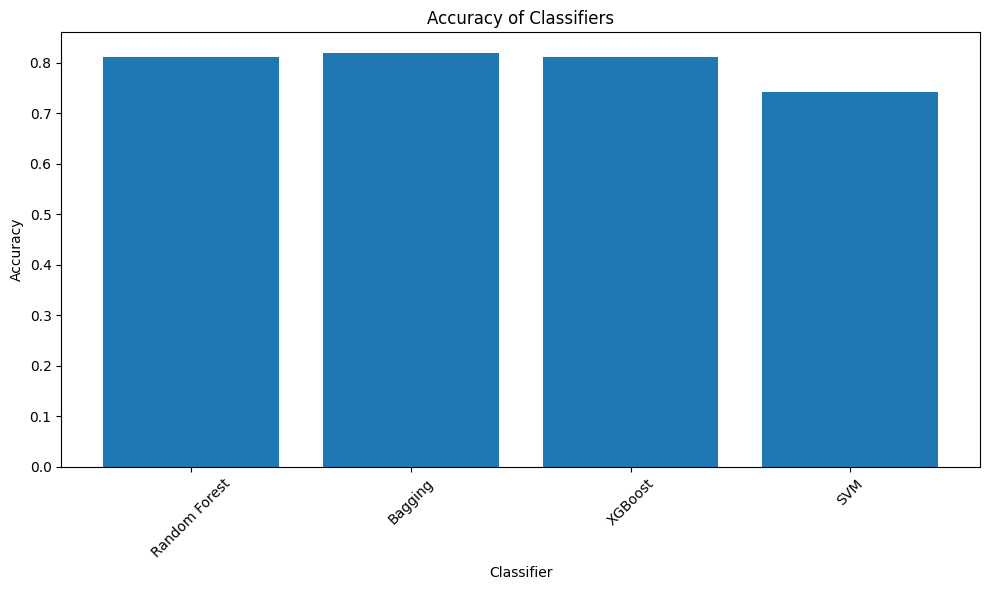


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_sum.pkl


In [10]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/cubert_embeddings/processed_embeddings/cubert_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# Plbart-base

Classification using AVG embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
F1_micro: 0.8133
F1_macro: 0.7729
Precision_macro: 0.7625
Recall_macro: 0.7886
Accuracy: 0.8133

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       814
           1       0.63      0.74      0.68       295

    accuracy                           0.81      1109
   macro avg       0.76      0.79      0.77      1109
weighted avg       0.83      0.81      0.82      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 50}
F1_micro: 0.8296
F1_macro: 0.7781
Precision_macro: 0.7831
Recall_macro: 0.7737
Accuracy: 0.8296

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       814
           1       0.69      0.65      0.67       295

    accu

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50}
F1_micro: 0.8269
F1_macro: 0.7778
Precision_macro: 0.7784
Recall_macro: 0.7772
Accuracy: 0.8269

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       814
           1       0.68      0.67      0.67       295

    accuracy                           0.83      1109
   macro avg       0.78      0.78      0.78      1109
weighted avg       0.83      0.83      0.83      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
F1_micro: 0.7917
F1_macro: 0.7591
Precision_macro: 0.7467
Recall_macro: 0.7933
Accuracy: 0.7917

Classification_report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       814
           1       0.58      0.80      0.67       295

    accuracy                           0.79      1109
   macro avg       0.75      0

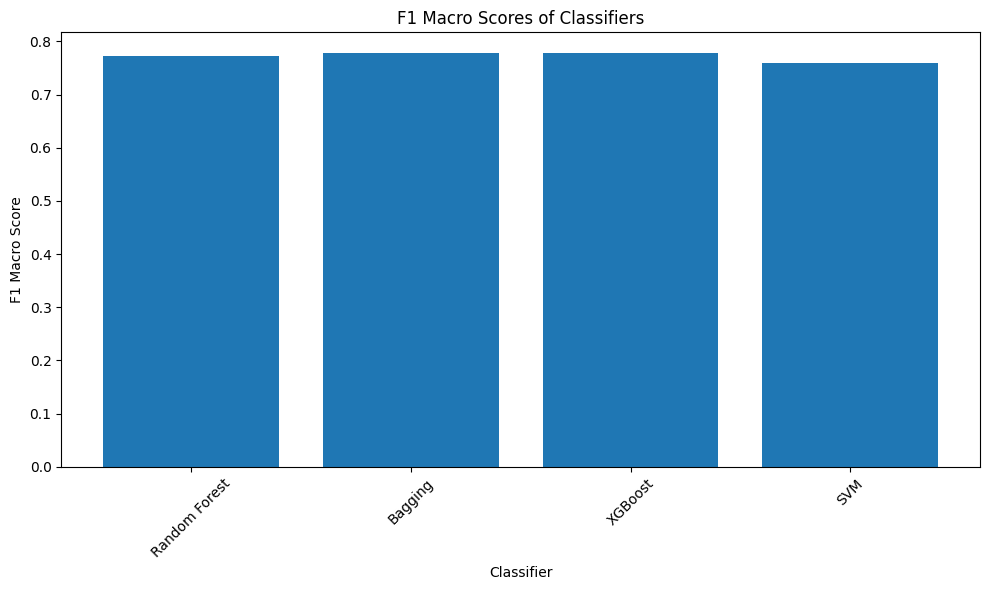

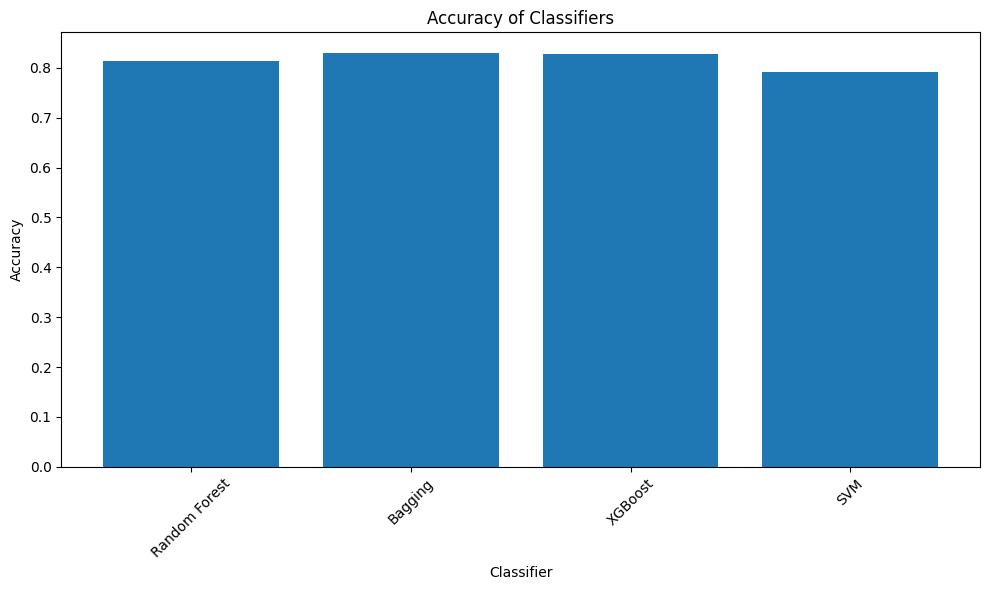


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_avg.pkl


In [12]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/plbart_base_embeddings/processed_embeddings/plbart_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
F1_micro: 0.8115
F1_macro: 0.7690
Precision_macro: 0.7598
Recall_macro: 0.7819
Accuracy: 0.8115

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       814
           1       0.63      0.72      0.67       295

    accuracy                           0.81      1109
   macro avg       0.76      0.78      0.77      1109
weighted avg       0.82      0.81      0.82      1109


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 100}
F1_micro: 0.8251
F1_macro: 0.7688
Precision_macro: 0.7787
Recall_macro: 0.7609
Accuracy: 0.8251

Classification_report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       814
           1       0.69      0.62      0.65       295

    acc

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
F1_micro: 0.8278
F1_macro: 0.7773
Precision_macro: 0.7802
Recall_macro: 0.7746
Accuracy: 0.8278

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       814
           1       0.68      0.66      0.67       295

    accuracy                           0.83      1109
   macro avg       0.78      0.77      0.78      1109
weighted avg       0.83      0.83      0.83      1109


Tuning SVM...

SVM Results:
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
F1_micro: 0.7592
F1_macro: 0.7329
Precision_macro: 0.7277
Recall_macro: 0.7841
Accuracy: 0.7592

Classification_report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       814
           1       0.53      0.84      0.65       295

    accuracy                           0.76      1109
   macro avg       0.73  

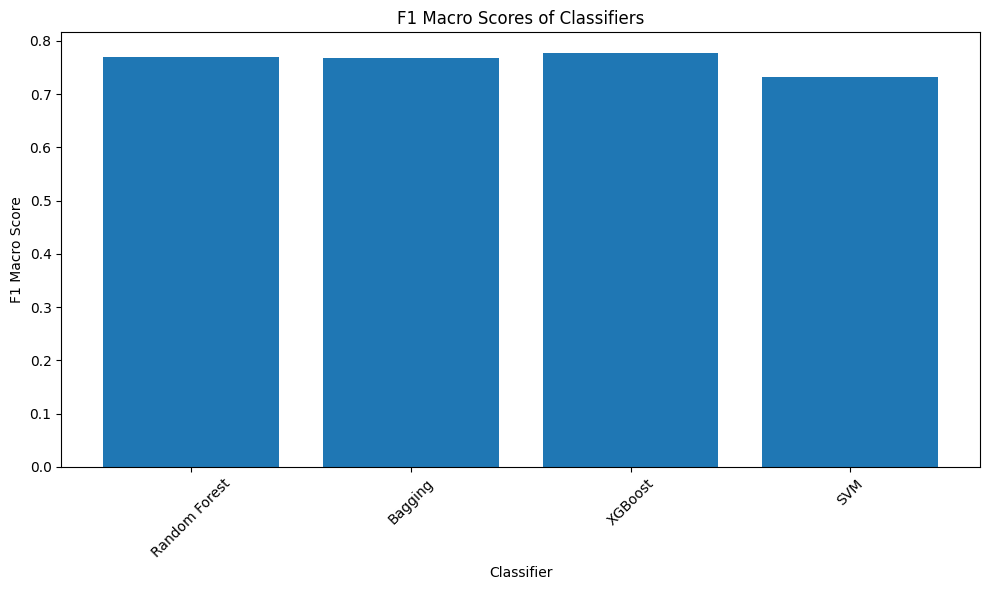

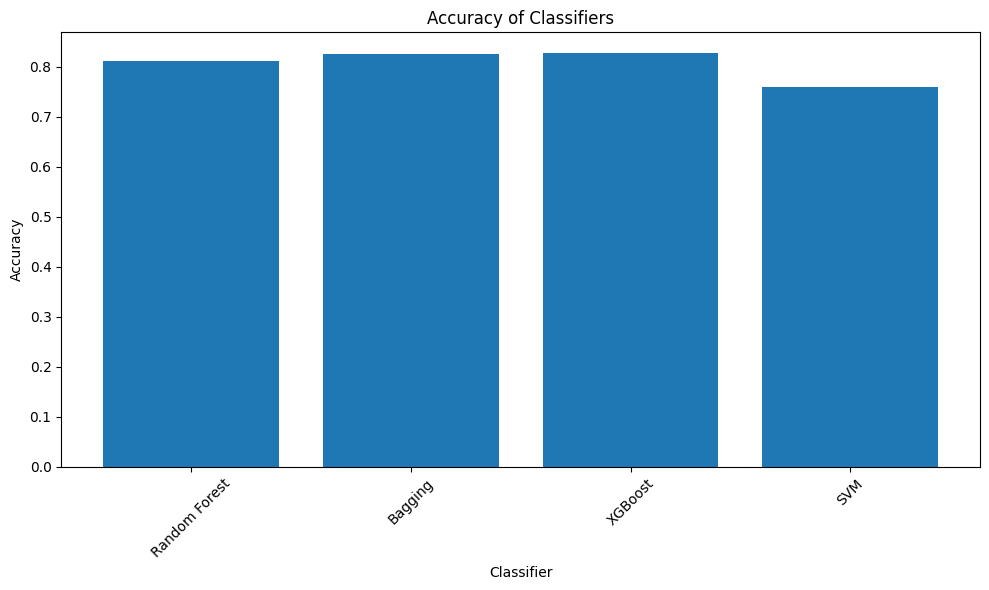


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_sum.pkl


In [13]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/plbart_base_embeddings/processed_embeddings/plbart_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_sum.pkl"  
process_embeddings_and_train(file_path, output_path)